In [2]:
import os
import pandas as pd

folder = "data"

# Collect files starting with RS and RC
rs_files = [f for f in os.listdir(folder) if f.startswith("RS") and f.endswith(".csv")]
rc_files = [f for f in os.listdir(folder) if f.startswith("RC") and f.endswith(".csv")]

def get_common_columns(files):
    """Return the intersection of column names for a list of CSV files."""
    common_cols = None
    for filename in files:
        path = os.path.join(folder, filename)
        df = pd.read_csv(path, nrows=0)  # read only header
        cols = set(df.columns)
        if common_cols is None:
            common_cols = cols
        else:
            common_cols |= cols
    return common_cols or set()

rs_common = get_common_columns(rs_files)
rc_common = get_common_columns(rc_files)

print("Common columns in RS files:", rs_common)
print("Common columns in RC files:", rc_common)

print("Total number of columns in RS files:", len(rs_common))
print("Total number of columns in RC files:", len(rc_common))


Common columns in RS files: {'author_flair_template_id', 'removal_reason', 'subreddit', 'allow_live_comments', 'link_flair_text_color', 'is_meta', 'send_replies', 'author_premium', 'link_flair_background_color', 'is_created_from_ads_ui', 'author_flair_background_color', 'spoiler', 'whitelist_status', 'link_flair_css_class', 'poll_data', 'author_flair_text_color', 'previous_selftext', 'author_flair_type', 'thumbnail_width', 'author_patreon_flair', 'post_hint', 'title', 'view_count', 'likes', 'mod_note', 'category', 'secure_media', 'thumbnail', 'discussion_type', 'permalink', 'author_flair_text', 'banned_by', 'approved_by', 'mod_reports', 'media_metadata', 'author_is_blocked', 'crosspost_parent', 'num_comments', 'awarders', 'pinned', 'approved_at_utc', 'link_flair_type', 'report_reasons', 'distinguished', 'gallery_data', 'edited', 'removed_by', 'suggested_sort', 'url', 'author', 'is_original_content', 'ups', 'subreddit_name_prefixed', 'link_flair_template_id', 'created', 'id', 'hidden', 

First we need to load data and find out which columns will we use for analysis. Reddit submissions contains 120 columns and comments 74. Obviously we won't use them all, so we need to choose the most important.

In [3]:
rs_columns = ['id', 'author', 'created_utc', 'subreddit', 'title', 'selftext',
 'link_flair_text', 'domain', 'score', 'ups', 'downs', 'num_comments',
 'upvote_ratio', 'total_awards_received', 'retrieved_on', 'is_original_content']

rc_columns = ['id', 'author', 'created_utc', 'subreddit', 'body', 'score',
 'ups', 'downs', 'parent_id', 'link_id', 'is_submitter', 
 'controversiality', 'total_awards_received', 'retrieved_on']

We decided to leave those columns as they give us almost all information we need to conduct our analysis and get some meaningful results. We may alter these during our experiments and analysis.

In [8]:
def read_subset(file, columns, source_type):
    path = os.path.join(folder, file)
    try:
        df = pd.read_csv(path, usecols=lambda c: c in columns)
        df = df.reindex(columns=columns)
        df["source_type"] = source_type
        return df
    except Exception as e:
        print(f"⚠️ Skipping {file}: {e}")
        return pd.DataFrame(columns=columns + ["source_type"])

rs_dfs = [read_subset(f, rs_columns, "submission") for f in rs_files]
rc_dfs = [read_subset(f, rc_columns, "comment") for f in rc_files]



In [4]:
# submissions_df = pd.concat(rs_dfs, ignore_index=True)
# comments_df = pd.concat(rc_dfs, ignore_index=True)
submissions_df = pd.read_csv("preprocessed/reddit_submissions_filtered.csv")
comments_df = pd.read_csv("preprocessed/reddit_comments_filtered.csv")

/var/folders/dq/jlc8hp0x7k3g20mjngvcsxqc0000gp/T/ipykernel_29872/2052800794.py:4: DtypeWarning: Columns (5,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_df = pd.read_csv("preprocessed/reddit_comments_filtered.csv")


In [5]:
print(f"✅ Submissions DataFrame: {len(submissions_df):,} rows, {len(submissions_df.columns)} columns")
print(f"✅ Comments DataFrame: {len(comments_df):,} rows, {len(comments_df.columns)} columns")

✅ Submissions DataFrame: 355,382 rows, 17 columns
✅ Comments DataFrame: 11,613,823 rows, 15 columns


In [12]:
# submissions_df.to_csv("preprocessed/reddit_submissions_filtered.csv", index=False)
# comments_df.to_csv("preprocessed/reddit_comments_filtered.csv", index=False)

In [17]:
# comments_df["link_id_clean"] = comments_df["link_id"].str.replace("t3_", "", regex=False)
# 
# joined_df = comments_df.merge(
#     submissions_df,
#     left_on="link_id_clean",
#     right_on="id",
#     # how="left",
#     suffixes=("_comment", "_submission")
# )



In [6]:
# joined_df.to_csv("preprocessed/reddit_combined.csv", index=False)
joined_df = pd.read_csv("preprocessed/reddit_combined.csv")

/var/folders/dq/jlc8hp0x7k3g20mjngvcsxqc0000gp/T/ipykernel_29872/3496338936.py:2: DtypeWarning: Columns (5,6,10,11,12,13,18,27,28,31) have mixed types. Specify dtype option on import or set low_memory=False.
  joined_df = pd.read_csv("preprocessed/reddit_combined.csv")


Ok, so now that we have our data filtered we can start exploring our data more thoroughly.
We will mainly explore both datasets simultaneously, applying quite similar changes. 
To begin, we need to filter out data that has nothing to do with elections. We will use keyword search and filter out data that doesn't have none of next keywords.

In [23]:
# import re
# keywords = [
#     # Domestic
#     'election', 'vote', 'voting', 'ballots', 'campaign', 'polls', 'polling', 'debate',
#     'liberal', 'conservative', 'ndp', 'bloc', 'green party', 'ppc', "people's party",
#     'carney', 'mark carney', 'trudeau', 'justin trudeau', 'prime minister',
#     'leadership race', 'minority government', 'majority government',
#     'coalition', 'confidence vote', 'cabinet', 'mp', 'riding', 'parliament',
#     'candidate', 'seat', 'platform', 'policy', 'promises',
# 
#     # International
#     'trump', 'usa', 'united states', 'america', 'american', 'tariffs', 'trade war',
#     'annexation', 'border', 'nafta', 'usmca', 'foreign policy', 'sanctions',
#     'biden', 'washington', 'white house', 'congress',
# 
#     # Issues
#     'inflation', 'economy', 'housing', 'immigration', 'refugees', 'carbon tax',
#     'climate change', 'healthcare', 'indigenous', 'reconciliation',
#     'gun control', 'freedom convoy', 'protest', 'corruption', 'scandal',
#     'china', 'russia', 'ukraine', 'nato', 'defense', 'war'
# ]
# 
# pattern = re.compile('|'.join([re.escape(k) for k in keywords]), flags=re.IGNORECASE)
# 
# election_submissions = submissions_df[
#     submissions_df['title'].fillna('').str.contains(pattern) |
#     submissions_df['selftext'].fillna('').str.contains(pattern)
# ]
# election_comments = comments_df[
#     comments_df['body'].fillna('').str.contains(pattern)
# ]

In [7]:
# election_submissions.to_csv("processed/election_submissions.csv", index=False)
# election_comments.to_csv("processed/election_comments.csv", index=False)

election_submissions = pd.read_csv("processed/election_submissions.csv")
election_comments = pd.read_csv("processed/election_comments.csv")


First, let's see how the dynamic between election related and other topics changed over time

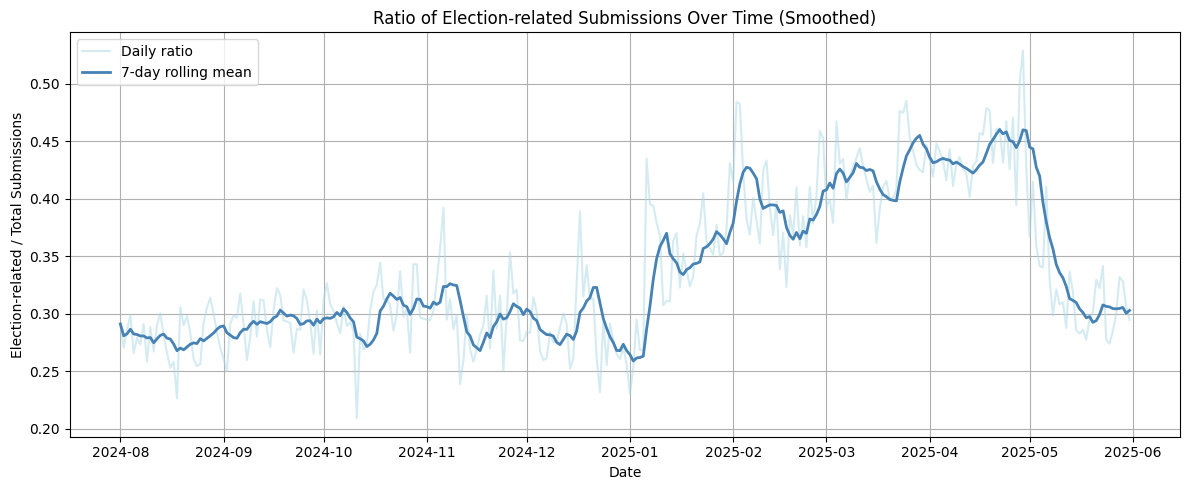

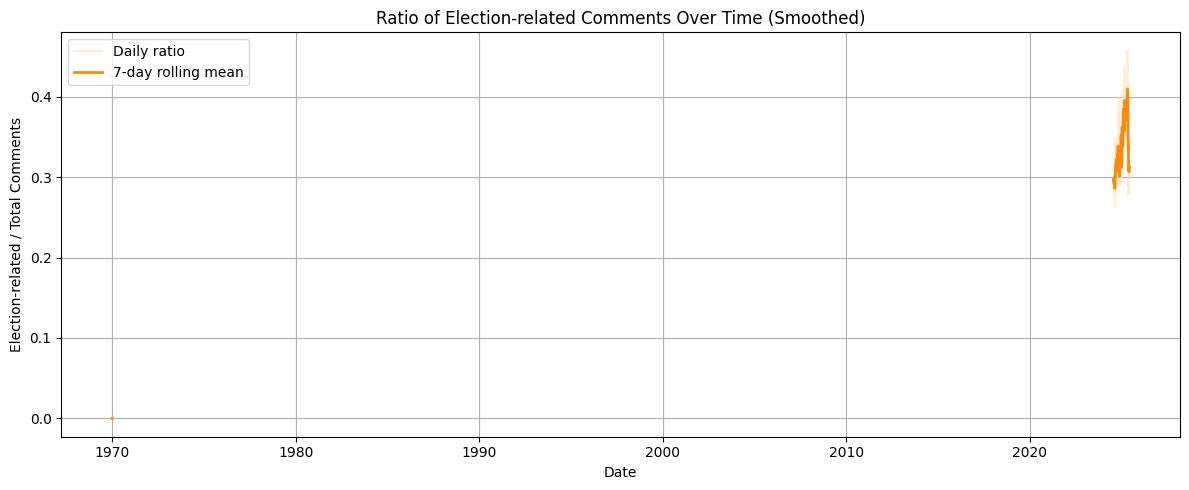

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Convert timestamps to datetime if not already
for df in [election_submissions, election_comments, submissions_df, comments_df]:
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')

# 2️⃣ Group by day
submissions_daily = (
    submissions_df.groupby(pd.Grouper(key='created_utc', freq='D'))
    .size()
    .rename('total_submissions')
)

election_submissions_daily = (
    election_submissions.groupby(pd.Grouper(key='created_utc', freq='D'))
    .size()
    .rename('election_submissions')
)

comments_daily = (
    comments_df.groupby(pd.Grouper(key='created_utc', freq='D'))
    .size()
    .rename('total_comments')
)

election_comments_daily = (
    election_comments.groupby(pd.Grouper(key='created_utc', freq='D'))
    .size()
    .rename('election_comments')
)

# 3️⃣ Merge data
submissions_trend = pd.concat([submissions_daily, election_submissions_daily], axis=1).fillna(0)
comments_trend = pd.concat([comments_daily, election_comments_daily], axis=1).fillna(0)

# 4️⃣ Compute ratios
submissions_trend['ratio'] = submissions_trend['election_submissions'] / submissions_trend['total_submissions']
comments_trend['ratio'] = comments_trend['election_comments'] / comments_trend['total_comments']

# 5️⃣ Smooth (7-day rolling mean)
submissions_trend['ratio_smooth'] = submissions_trend['ratio'].rolling(window=7, min_periods=1).mean()
comments_trend['ratio_smooth'] = comments_trend['ratio'].rolling(window=7, min_periods=1).mean()

# 6️⃣ Plot — Submissions
plt.figure(figsize=(12, 5))
plt.plot(submissions_trend.index, submissions_trend['ratio'], color='lightblue', alpha=0.5, label='Daily ratio')
plt.plot(submissions_trend.index, submissions_trend['ratio_smooth'], color='steelblue', linewidth=2, label='7-day rolling mean')
plt.title('Ratio of Election-related Submissions Over Time (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Election-related / Total Submissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7️⃣ Plot — Comments
plt.figure(figsize=(12, 5))
plt.plot(comments_trend.index, comments_trend['ratio'], color='navajowhite', alpha=0.5, label='Daily ratio')
plt.plot(comments_trend.index, comments_trend['ratio_smooth'], color='darkorange', linewidth=2, label='7-day rolling mean')
plt.title('Ratio of Election-related Comments Over Time (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Election-related / Total Comments')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From this plot we can clearly see that topicality of elections increases as  time to elections reduces. We also see different spikes(e.g. Trump inauguration), which are expected as they increased political and elections debate.
We can also notice that comments have higher ratio, which could be explained by the fact that politics is more controverisial topic than cats dogs or canadian forests.

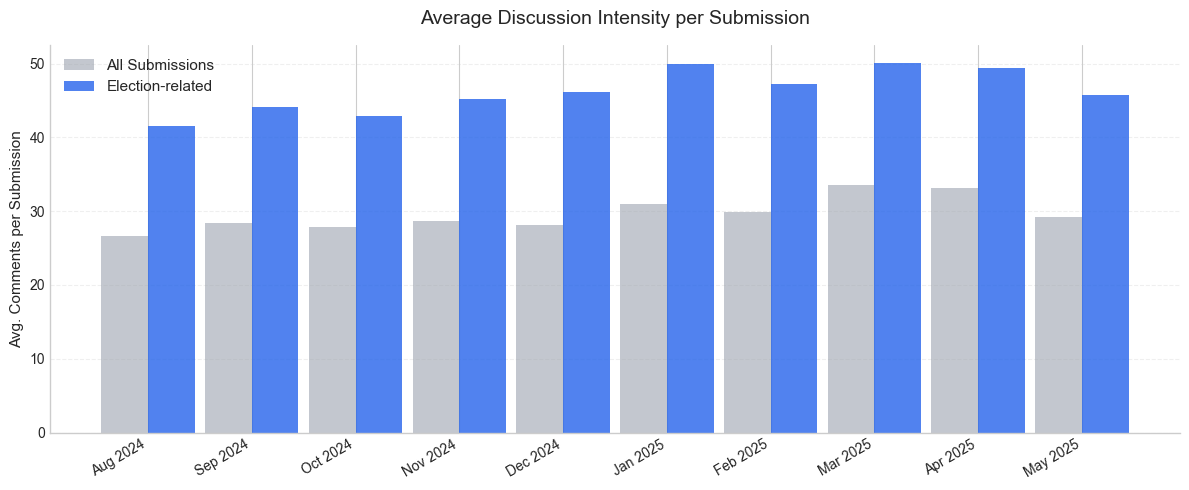

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Ensure datetime
submissions_df['created_utc'] = pd.to_datetime(submissions_df['created_utc'], unit='s', errors='coerce')

# 2️⃣ Label election-related submissions
submissions_df['is_election_related'] = submissions_df['id'].isin(election_submissions['id'])

# 3️⃣ Compute monthly averages
#    - overall avg comments per submission
#    - avg comments per election-related submission
monthly_total_avg = (
    submissions_df.groupby(pd.Grouper(key='created_utc', freq='M'))['num_comments']
    .mean()
    .rename('All Submissions')
)
monthly_election_avg = (
    submissions_df[submissions_df['is_election_related']]
    .groupby(pd.Grouper(key='created_utc', freq='M'))['num_comments']
    .mean()
    .rename('Election-related')
)

# Merge both series
monthly_avg_comments = pd.concat([monthly_total_avg, monthly_election_avg], axis=1).fillna(0)

# 4️⃣ Minimal clean plot
plt.figure(figsize=(12, 5))
plt.style.use('seaborn-v0_8-whitegrid')

x = np.arange(len(monthly_avg_comments))
width = 0.45

# Bars
plt.bar(x - width/2, monthly_avg_comments['All Submissions'], width,
        label='All Submissions', color='#9CA3AF', alpha=0.6)
plt.bar(x + width/2, monthly_avg_comments['Election-related'], width,
        label='Election-related', color='#2563EB', alpha=0.8)

# Axis & labels
plt.xticks(x, monthly_avg_comments.index.strftime('%b %Y'), rotation=30, ha='right')
plt.ylabel('Avg. Comments per Submission', fontsize=11)
plt.title('Average Discussion Intensity per Submission', fontsize=14, pad=15)
plt.legend(frameon=False, fontsize=11)

# Clean look
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


Looking at the barchart, we can clearly see that election-related submissions received greater number of comments on average throughout all research period.
Now, let's take a look at one more thing: let's look at dynamics of upvotes, downvotes and score of posts on average.

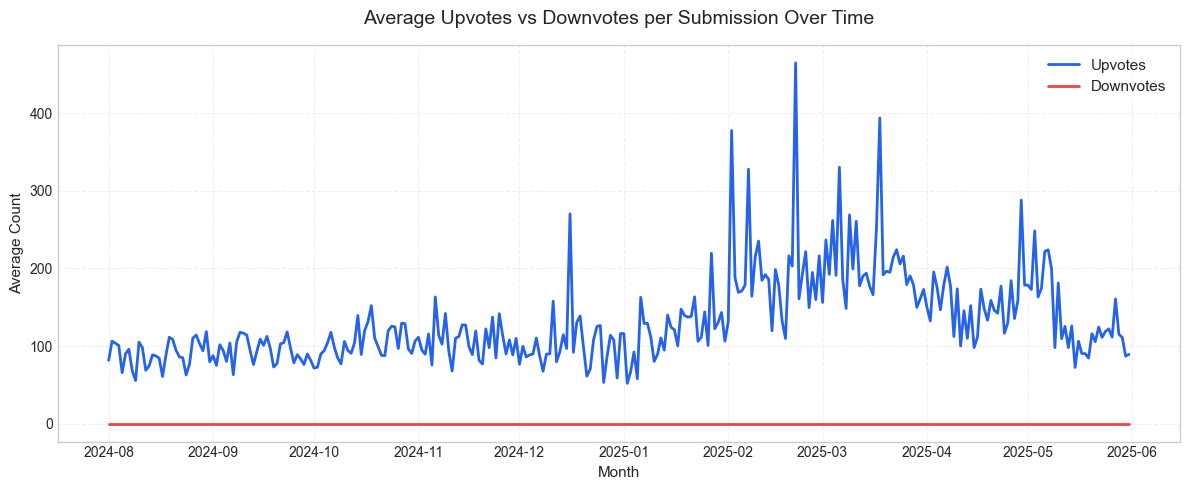

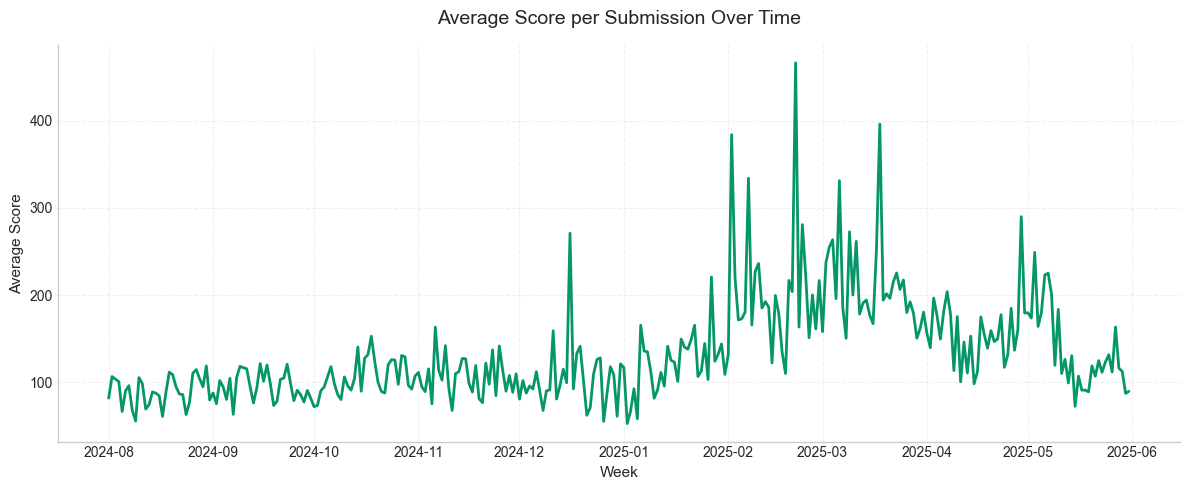

In [19]:
election_submissions['created_utc'] = pd.to_datetime(election_submissions['created_utc'], unit='s', errors='coerce')

# 2️⃣ Group by month and compute mean values
monthly_metrics = (
    election_submissions
    .groupby(pd.Grouper(key='created_utc', freq='d'))[['ups', 'downs', 'score']]
    .mean()
)

plt.figure(figsize=(12, 5))
plt.plot(monthly_metrics.index, monthly_metrics['ups'], label='Upvotes', color='#2563EB', linewidth=2)
plt.plot(monthly_metrics.index, monthly_metrics['downs'], label='Downvotes', color='#EF4444', linewidth=2)

plt.title('Average Upvotes vs Downvotes per Submission Over Time', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=11)
plt.ylabel('Average Count', fontsize=11)
plt.legend(frameon=False, fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(monthly_metrics.index, monthly_metrics['score'], color='#059669', linewidth=2)

plt.title('Average Score per Submission Over Time', fontsize=14, pad=15)
plt.xlabel('Week', fontsize=11)
plt.ylabel('Average Score', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

To be honest, these graphs weren't as informative as I thought they would be. Anyway, we discovered that there is no stats on downs as reddit hid them several years ago. We can nevertheless try to extract info on both conservatives and liberals from election dataframe and look how they scored throughout campaign. 

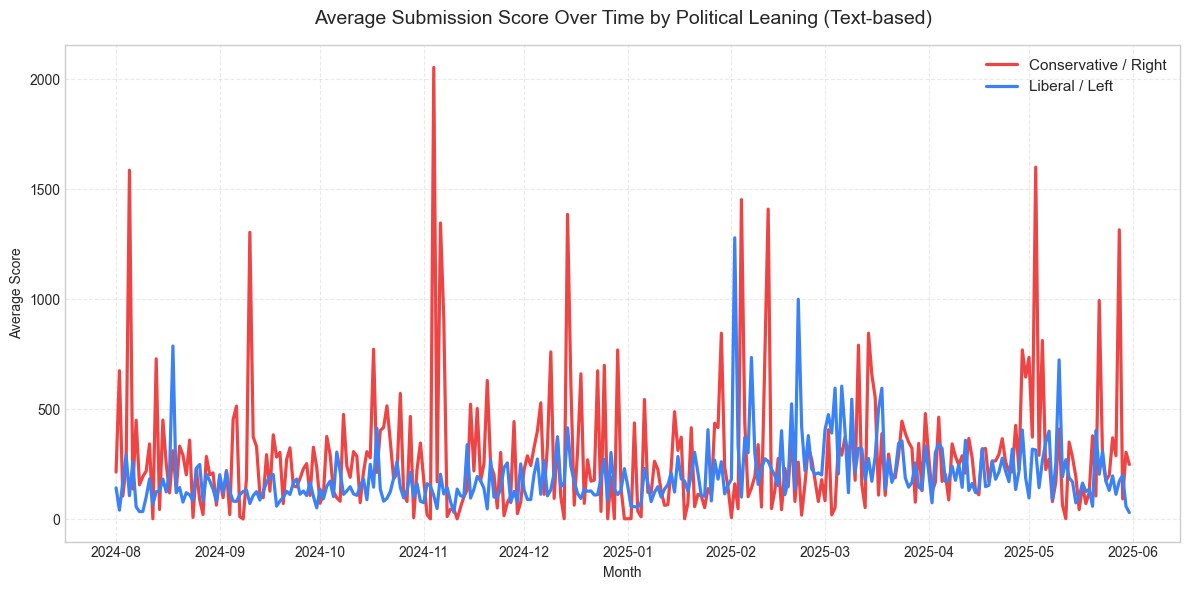

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1️⃣ Ensure datetime
election_submissions['created_utc'] = pd.to_datetime(election_submissions['created_utc'], unit='s', errors='coerce')

# 2️⃣ Combine text fields
election_submissions['full_text'] = (
    (election_submissions['title'].fillna('') + ' ' + election_submissions['selftext'].fillna('')).str.lower()
)

# 3️⃣ Define keyword sets
liberal_keywords = [
    'liberal', 'trudeau', 'mark carney', 'freeland', 'ndp', 'green party', 
    'progressive', 'left-wing', 'liberals', 'canada liberals'
]

conservative_keywords = [
    'conservative', 'poilievre', 'right-wing', 'tory', 'ppc', 
    'peoples party', 'reform party', 'harper'
]

# 4️⃣ Categorization by text matching
def categorize_text(text):
    text = text.lower()
    if any(re.search(rf'\b{kw}\b', text) for kw in liberal_keywords):
        return 'Liberal / Left'
    elif any(re.search(rf'\b{kw}\b', text) for kw in conservative_keywords):
        return 'Conservative / Right'

election_submissions['political_category'] = election_submissions['full_text'].apply(categorize_text)

# 5️⃣ Compute monthly average score
score_trends = (
    election_submissions.groupby([pd.Grouper(key='created_utc', freq='d'), 'political_category'])['score']
    .mean()
    .unstack(fill_value=0)
)

# 6️⃣ Plot
plt.figure(figsize=(12, 6))

colors = {
    'Liberal / Left': '#3B82F6',        # синій
    'Conservative / Right': '#EF4444',  # червоний   # фіолетовий
}

for col in score_trends.columns:
    plt.plot(score_trends.index, score_trends[col],
             label=col,
             linewidth=2.3,
             color=colors.get(col, '#000000'))

plt.title('Average Submission Score Over Time by Political Leaning (Text-based)', fontsize=14, pad=15)
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.legend(frameon=False, fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
